2023.11.26 尝试实现SSD目标检测模型

In [15]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [3]:
def cls_predictor(num_inputs, num_anchors, num_classes):
    """ 类别预测层：输入输出大小不变，输出通道表示输入上每个像素第i个锚框第j类的预测 i(q+1)+j\n
        @num_inputs:输入通道数\n
        @num_anchors:特征图每个像素位置生成num_anchors个锚框，即a\n
        @num_classes:共有num_classes个类别，即q\n"""
    return nn.Conv2d(in_channels=num_inputs, out_channels=num_anchors * (num_classes + 1),
                     kernel_size=3, padding=1)

In [4]:
def bbox_predictor(num_inputs, num_anchors):
    """ 边界框预测层：类似cls_predictor，输入输出大小不变，为每个anchor预测4个位置偏移量 """
    return nn.Conv2d(in_channels=num_inputs, out_channels=num_anchors * 4,
                     kernel_size=3, padding=1)

In [5]:
# 连结多尺度的预测
def forward(x, block):
    """ 即执行 block(x) """
    return block(x)

Y1 = forward(torch.zeros(size=(2, 8, 20, 20)), cls_predictor(8, 5, 10))     # 输入特征图BCHW
Y2 = forward(torch.zeros(size=(2, 16, 10, 10)), cls_predictor(16, 3, 10))   # 输入特征图BCHW
Y1.shape, Y2.shape      # [2, 5 * (10 + 1) = 55, 20, 20]    [2, 3 * (10 + 1) = 33, 10, 10]，将这2个尺度的预测结果连接起来，提高计算效率

(torch.Size([2, 55, 20, 20]), torch.Size([2, 33, 10, 10]))

In [6]:
def flatten_pred(pred):
    """ 将[B,C,H,W]展平为[B,H*W*C] """
    return torch.flatten(input=pred.permute(0, 2, 3, 1), start_dim=1)

def concat_preds(preds):
    """ 将多个[B,H*W*C]在维度1上连结起来 """
    return torch.cat([flatten_pred(p) for p in preds], dim=1)

concat_preds([Y1, Y2]).shape

torch.Size([2, 25300])

In [7]:
def down_sample_blk(in_channels, out_channels):
    """ 高宽减半块 2*Conv + 1*MaxPool \n
        通道数 """
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    blk.append(nn.MaxPool2d(kernel_size=2))     # MaxPool2d stride默认等于kernel_size
    return nn.Sequential(*blk)

forward(torch.zeros(size=(2, 3, 20, 20)), down_sample_blk(in_channels=3, out_channels=10)).shape      # [2,3,20,20] --> [2,10,10,10]

torch.Size([2, 10, 10, 10])

In [8]:
def base_net():
    """ 基本网络块，抽取特征 3*down_sample_blk """
    blk = []
    num_filters = [3, 16, 32, 64]
    for i in range(len(num_filters) - 1):
        blk.append(down_sample_blk(in_channels=num_filters[i], out_channels=num_filters[i + 1]))
    return nn.Sequential(*blk)

forward(torch.zeros(size=(2, 3, 256, 256)), base_net()).shape       # [2, 3, 256, 256] --> [2, 64, 256/2^3=32, 256/2^3=32]

torch.Size([2, 64, 32, 32])

In [9]:
""" 完整的模型 """
def get_blk(i):
    """ 用于构建完整模型 """
    if i == 0:          # 索引第0个模块，base_net
        return base_net()
    elif i == 1:        # 索引第1个模块，down_sample_blk
        return down_sample_blk(in_channels=64, out_channels=128)
    elif i == 4:        # 索引第4个模块，GAP层
        return nn.AdaptiveAvgPool2d(output_size=(1, 1))
    else:               # 索引第2、3个模块，down_sample_blk
        return down_sample_blk(in_channels=128, out_channels=128)


In [10]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    """ 执行前向传播，得到某层的特征图、anchors及其预测结果\n
        @cls_predictor:类别预测层，实际是Conv，回忆一下是不是\n
        @bbox_predictor:边界框预测层，实际是Conv\n
        输出包括:CNN特征图Y、生成的锚框anchors、anchors预测类别、偏移量 """
    # print(f'$$$$$$ {X.shape}', blk, end='')
    Y = blk(X)
    # print(f'$$$$$$ {Y.shape}')
    anchors = d2l.multibox_prior(Y, sizes=size, ratios=ratio)           # 【一定要在.py中进去debug】
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

In [11]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

In [12]:
class TinySSD(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_in_channels = [64, 128, 128, 128, 128]
        for i in range(5):
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(self, f'cls_{i}', cls_predictor(num_inputs=idx_to_in_channels[i], num_anchors=num_anchors, num_classes=num_classes))        # 即self.cls_i=Conv
            setattr(self, f'bbox_{i}', bbox_predictor(num_inputs=idx_to_in_channels[i], num_anchors=num_anchors))                               # 即self.bbox_i=Conv
        
    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(X, 
                                                                     getattr(self, f'blk_{i}'), 
                                                                     sizes[i], 
                                                                     ratios[i], 
                                                                     getattr(self, f'cls_{i}'), 
                                                                     getattr(self, f'bbox_{i}'))
        # 【以下维度要debug】
        anchors = torch.cat(anchors, dim=1)
        cls_preds = concat_preds(cls_preds)
        cls_preds = cls_preds.reshape(cls_preds.shape[0], -1, self.num_classes + 1)
        bbox_preds = concat_preds(bbox_preds)
        return anchors, cls_preds, bbox_preds

In [13]:
# 实例化一个模型
net = TinySSD(num_classes=1)
X = torch.zeros(size=(32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)
print(f'output anchors shape:{anchors.shape}\n'
      f'output class preds shape:{cls_preds.shape}\n'
      f'output bbox preds shape:{bbox_preds.shape}')

output anchors shape:torch.Size([1, 5444, 4])
output class preds shape:torch.Size([32, 5444, 2])
output bbox preds shape:torch.Size([32, 21776])


In [14]:
# 读取数据集和初始化
batch_size = 32
train_iter, _ = d2l.load_data_bananas(batch_size)

read 1000 training examples
read 100 validation examples


In [16]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f'device = {device}')
net = TinySSD(num_classes=1)
trainer = torch.optim.SGD(params=net.parameters(), lr=0.2, weight_decay=5e-4)

device = mps


In [17]:
cls_loss = nn.CrossEntropyLoss(reduction='none')
bbox_loss = nn.L1Loss(reduction='none')

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1, num_classes),
                   cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
    bbox = bbox_loss(bbox_preds * bbox_masks,
                     bbox_labels * bbox_masks).mean(dim=1)
    return cls + bbox

In [18]:
def cls_eval(cls_preds, cls_labels):
    # 由于类别预测结果放在最后一维，argmax需要指定最后一维。
    return float((cls_preds.argmax(dim=-1).type(
        cls_labels.dtype) == cls_labels).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

class err 2.37e-01, bbox mae 1.09e-02
6049.0 examples/sec on mps


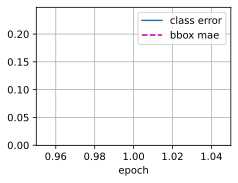

In [20]:
num_epochs, timer = 1, d2l.Timer()
animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=['class error', 'bbox mae'])
net = net.to(device)
for epoch in range(num_epochs):
    # 训练精确度的和，训练精确度的和中的示例数
    # 绝对误差的和，绝对误差的和中的示例数
    metric = d2l.Accumulator(4)
    net.train()
    for features, target in train_iter:
        timer.start()
        trainer.zero_grad()
        X, Y = features.to(device), target.to(device)
        # 生成多尺度的锚框，为每个锚框预测类别和偏移量
        anchors, cls_preds, bbox_preds = net(X)
        # 为每个锚框标注类别和偏移量
        bbox_labels, bbox_masks, cls_labels = d2l.multibox_target(anchors, Y)
        # 根据类别和偏移量的预测和标注值计算损失函数
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                      bbox_masks)
        l.mean().backward()
        trainer.step()
        metric.add(cls_eval(cls_preds, cls_labels), cls_labels.numel(),
                   bbox_eval(bbox_preds, bbox_labels, bbox_masks),
                   bbox_labels.numel())
    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]
    animator.add(epoch + 1, (cls_err, bbox_mae))
print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{len(train_iter.dataset) / timer.stop():.1f} examples/sec on '
      f'{str(device)}')

In [21]:
# 预测目标
X = torchvision.io.read_image('/Users/sunchengcheng/Projects/D2L/data/banana-detection/bananas_val/images/0.png').unsqueeze(0).float()
img = X.squeeze(0).permute(1, 2, 0).long()

In [22]:
def predict(X):
    net.eval()
    anchors, cls_preds, bbox_preds = net(X.to(device))
    cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1)
    output = d2l.multibox_detection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]

output = predict(X)

KeyboardInterrupt: 

In [ ]:
def display(img, output, threshold):
    d2l.set_figsize((5, 5))
    fig = d2l.plt.imshow(img)
    for row in output:
        score = float(row[1])
        if score < threshold:
            continue
        h, w = img.shape[0:2]
        # print(f'$$$$$$$$ {h} {w}')
        bbox = [row[2:6] * torch.tensor((w, h, w, h), device=row.device)]
        d2l.show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')

display(img, output.cpu(), threshold=0.9)

NameError: name 'output' is not defined

In [ ]:
output.shape

torch.Size([1, 6])